In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urllib
import requests
import time
import japanize_matplotlib
from sklearn.metrics import mean_squared_error
from scipy import stats as st
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.preprocessing import LabelEncoder
import pickle
import os
import lightgbm as lgb
import unicodedata
from sklearn.model_selection import train_test_split,KFold,GroupKFold

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
sub=pd.read_csv("submit_sample.csv",names=["id","price"])

In [3]:
df=pd.concat([train,test]).drop("state",axis=1)

# データ整形

In [4]:
import unicodedata
foo = u'１２３４５６７８９０'

In [5]:
# dfはあなたのデータフレームです
df['manufacturer'] = df['manufacturer'].apply(lambda x: unicodedata.normalize('NFKC', x))
df["manufacturer"]=df["manufacturer"].apply(lambda x:x.lower())

In [6]:
df["cylinders"]=df["cylinders"].apply(lambda x: 0 if x[0]=="o" else int(x[0]) )

In [7]:
# ハイフンを統一する
df["size"] = df["size"].replace("midーsize", "mid-size")
df["size"] = df["size"].replace("mid−size", "mid-size")
df["size"] = df["size"].replace("fullーsize","full-size")
df["size"] = df["size"].replace("full−size","full-size")
df["size"] = df["size"].replace("subーcompact","sub-compact")

In [8]:
condition_order = ["new", "like new", "excellent", "good", "fair", "salvage"]
df.loc[:,"condition"] = df["condition"].apply(lambda x: condition_order.index(x))
df.loc[:,"condition"].value_counts()
#0が一番良い新品、5が一番悪い故障あり

condition
2    30440
3    12020
1     7647
4     4773
0      116
5       73
Name: count, dtype: int64

In [9]:
df["year"]=df["year"].apply(lambda x:int(x)-1000 if int(x)>2200 else int(x))

In [10]:
df["odometer"]=df["odometer"].apply(lambda x: x/10 if x>1000000 else x)
df["odometer"]=df["odometer"].apply(lambda x: -x if x<=-10 else x)
df["odometer"]=df["odometer"].apply(lambda x: df["odometer"].mean() if x==-1 else x)


# 欠損値埋める

fuel

In [11]:
fuel_null_index=df[df["fuel"].isnull()].index
df.loc[fuel_null_index,"fuel"]="gas"

In [12]:
clean_index=df[df["title_status"].isnull()].index
df.loc[clean_index,"title_status"]="clean"

In [13]:
type_index=df[df["type"].isnull()].index
df.loc[type_index,"type"]="sedan"

# エンコーディング

In [14]:
train_df=df[df["price"].notnull()]
test_df=df[df["price"].isnull()]

In [15]:
int_columns=train_df.select_dtypes(["int","float"]).drop("id",axis=1)
object_columns=df.select_dtypes("object").columns

In [16]:
target_columns=["region"]
group_target=pd.concat([train_df[int_columns.columns],train_df[target_columns]],axis=1)
target_by_region=group_target.groupby(target_columns).describe()["price"][["mean","min","50%","max"]].reset_index()
target_by_region.columns=["region","region_mean","region_min","region_50","region_max"]
df=pd.merge(df,target_by_region,how="left",on="region")

In [38]:
list(target_columns)

['manufacturer',
 'condition',
 'fuel',
 'title_status',
 'transmission',
 'drive',
 'size',
 'type',
 'paint_color']

In [44]:
target_columns=list(object_columns[1:])
group_target=pd.concat([train_df[int_columns.columns],train_df[target_columns]],axis=1)
target_by_target=group_target.groupby(target_columns).describe()["price"][["mean","min","50%","max"]].reset_index()
target_by_target.columns=[target_columns,"all_mean","all_min","all_50","all_max"]
df=pd.merge(df,target_by_region,how="left",on=target_columns)

ValueError: Length mismatch: Expected axis has 13 elements, new values have 5 elements

In [48]:
flat_lst = [x for sub_lst in [target_columns,"all_mean","all_min","all_50","all_max"] for x in sub_lst]
[target_columns,"all_mean","all_min","all_50","all_max"]

[['manufacturer',
  'condition',
  'fuel',
  'title_status',
  'transmission',
  'drive',
  'size',
  'type',
  'paint_color'],
 'all_mean',
 'all_min',
 'all_50',
 'all_max']

In [17]:
# target_columns=[o]
# group_target=pd.concat([train_df[int_columns.columns],train_df[target_columns]],axis=1)
# target_by_region=group_target.groupby(target_columns).describe()["price"][["min","25%","50%","75%","max"]].reset_index()

In [18]:
le = LabelEncoder()

for i in object_columns:
    df[i]=le.fit_transform(df[i])
# group_target.groupby(target_columns).describe()

In [19]:
# df[a].value_counts()

In [20]:
# a="transmission"

In [21]:
# df[df["price"]>=30000][a].value_counts()

# train test

In [22]:
train_df=df[df["price"].notnull()]
test_df=df[df["price"].isnull()]

train_x=train_df.drop(["price"],axis=1)
train_y=train_df["price"]
test_x=test_df.drop(["price"],axis=1)
test_y=test_df["price"]
# train_df.to_csv("train_new.csv")

In [23]:
x_train,x_val,y_train,y_val = train_test_split(train_x,train_y,test_size=0.2)


In [25]:
feature_col=df.columns.drop(["id","region","manufacturer","price"])
object_columns=object_columns.drop(["region","manufacturer"])

In [28]:
clf = RandomForestRegressor()
clf = clf.fit(x_train[feature_col], y_train)
pred = clf.predict(x_val[feature_col])
# MAPEを計算する関数を定義する
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape(y_val,pred)

67.85518556758403

In [29]:
DIR = "./"
OUTPUT_DIR = os.path.join(DIR,"output")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
class CFG:
    VER=4
    MODEL_DATA_PATH = OUTPUT_DIR
    OOF_DATA_PATH = OUTPUT_DIR
    seed = 42
    n_folds = 5
    target_col = 'price'
    metric = 'mape'
    num_boost_round = 5000
    max_epochs = 2000
    early_stopping_rounds = 200
    verbose = 1000
    boosting_type = 'dart'
    lgb_params = {
      "objective":"regression",
      "metric":"mape",
      'verbosity': -1,
      'n_jobs': -1,
      'boosting_type': boosting_type,
      "n_estimators": num_boost_round,
      "random_state": seed,
      'learning_rate': 0.05, 
      'lambda_l1': 0.0024306941353027622, 
      'lambda_l2': 1.0645884032063444e-08, 
      'num_leaves': 18, 
      'feature_fraction': 0.7168918229680646, 
      'bagging_fraction': 0.9476636054626689, 
      'bagging_freq': 1, 
      'max_depth': 15, 
      'max_bin': 272, 
      'min_data_in_leaf': 8
    }


def lgb_training(x_train: pd.DataFrame, y_train: pd.DataFrame, x_valid: pd.DataFrame, y_valid: pd.DataFrame,
                 features: list, categorical_features: list):
    clf = lgb.LGBMRegressor(**CFG.lgb_params)
    clf.fit(x_train, y_train,
                eval_set=[(x_valid, y_valid)],
                eval_metric=CFG.metric,
                verbose = CFG.verbose,
              #early_stopping_rounds=100,
              #categorical_feature = categorical_features
              )
    # Predict validation
    valid_pred = clf.predict(x_valid)
    return clf, valid_pred


def cv_training(method: str, train_df: pd.DataFrame, features: list, categorical_features: list):
    scores, preds = [],[]
    oof = pd.DataFrame()
    lgb_importances = pd.DataFrame()
    kf = KFold(n_splits=5 ,shuffle=True, random_state=42)
    for fold ,(tr_idx,va_idx) in enumerate(kf.split(train_df)):
        print("="*20,f" {method} training fold {fold + 1} ","="*20)
        
        train_folds = train_df.iloc[tr_idx]
        valid_folds = train_df.iloc[va_idx]
        x_train = train_folds[features]
        x_valid = valid_folds[features]
        y_train = train_folds["price"]
        y_valid = valid_folds["price"]
            
      
        model, valid_pred = lgb_training(x_train, y_train, x_valid, y_valid, features, categorical_features)
        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = x_train.columns
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        #変更点
        lgb_importances = []
        lgb_importances.append(fi_tmp)
        lgb_importances=pd.concat(lgb_importances)

        # Save best model
        pickle.dump(model, open(os.path.join(CFG.MODEL_DATA_PATH, f'{method}_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'wb'))
            
        score = mape(y_valid,valid_pred)
        print(f"MAPE : {score}")
        scores.append(score)
            
        valid_folds[f"{method}_pred"] = valid_pred
        
        oof = pd.concat([oof,valid_folds])
        del x_train,y_train,x_valid,y_valid
        
    print(f"Mean Score {np.mean(scores)}")
    
    oof.to_csv('lightGBM_pred.csv', index = False)
    
    score = mape(oof["price"],oof[f"{method}_pred"])
    print(f"MAPE : {score}")
    order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)
    fig = plt.figure(figsize=(16, 32), tight_layout=True)
    sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
    plt.title("LightGBM feature importances")
    
def model_inference(method: str, test_df: pd.DataFrame, features: list, categorical_features: list):
    x_test = test_df[features]
    test_pred = lgb_inference(x_test)
    return test_pred

def lgb_inference(x_test: pd.DataFrame):
    test_pred = np.zeros(len(x_test))
    for fold in range(CFG.n_folds):
        model = pickle.load(open(os.path.join(CFG.MODEL_DATA_PATH,f'lightgbm_fold{fold + 1}_seed{CFG.seed}_ver{CFG.VER}.pkl'), 'rb'))
    # Predict
        test_pred += model.predict(x_test)
    return test_pred / CFG.n_folds

====================  lightgbm training fold 1  ====================
[LightGBM] [Warning] feature_fraction is set=0.7168918229680646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168918229680646
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.9476636054626689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9476636054626689
[LightGBM] [Warning] lambda_l1 is set=0.0024306941353027622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024306941353027622
[LightGBM] [Warning] lambda_l2 is set=1.0645884032063444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0645884032063444e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's mape: 0.646612
[2000]	valid_0's mape: 0.655009
[3000]	valid_0's mape: 0.658622
[4000]	valid_0's mape: 0.662468
[5000]	valid_0's mape: 0.663637
MAPE : 66.36370041662637
====================  lightgbm training fold 2  ====================
[LightGBM] [Warning] feature_fraction is set=0.7168918229680646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168918229680646
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.9476636054626689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9476636054626689
[LightGBM] [Warning] lambda_l1 is set=0.0024306941353027622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024306941353027622
[LightGBM] [Warning] lambda_l2 is set=1.0645884032063444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0645884032063444e-08
[LightGBM] [Warning] bagging_freq is set=1, 

C:\Users\zekus\AppData\Local\Temp\ipykernel_14144\3541173195.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{method}_pred"] = valid_pred
C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's mape: 0.628599
[2000]	valid_0's mape: 0.636884
[3000]	valid_0's mape: 0.639582
[4000]	valid_0's mape: 0.643843
[5000]	valid_0's mape: 0.643666
MAPE : 64.36664999903951
====================  lightgbm training fold 3  ====================
[LightGBM] [Warning] feature_fraction is set=0.7168918229680646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168918229680646
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.9476636054626689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9476636054626689
[LightGBM] [Warning] lambda_l1 is set=0.0024306941353027622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024306941353027622
[LightGBM] [Warning] lambda_l2 is set=1.0645884032063444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0645884032063444e-08
[LightGBM] [Warning] bagging_freq is set=1, 

C:\Users\zekus\AppData\Local\Temp\ipykernel_14144\3541173195.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{method}_pred"] = valid_pred
C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's mape: 0.623433
[2000]	valid_0's mape: 0.630836
[3000]	valid_0's mape: 0.63243
[4000]	valid_0's mape: 0.63729
[5000]	valid_0's mape: 0.639472
MAPE : 63.9471572831376
====================  lightgbm training fold 4  ====================
[LightGBM] [Warning] feature_fraction is set=0.7168918229680646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168918229680646
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.9476636054626689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9476636054626689
[LightGBM] [Warning] lambda_l1 is set=0.0024306941353027622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024306941353027622
[LightGBM] [Warning] lambda_l2 is set=1.0645884032063444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0645884032063444e-08
[LightGBM] [Warning] bagging_freq is set=1, sub

C:\Users\zekus\AppData\Local\Temp\ipykernel_14144\3541173195.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{method}_pred"] = valid_pred
C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's mape: 0.648643
[2000]	valid_0's mape: 0.655311
[3000]	valid_0's mape: 0.658479
[4000]	valid_0's mape: 0.663326
[5000]	valid_0's mape: 0.663086
MAPE : 66.30857849192621
====================  lightgbm training fold 5  ====================
[LightGBM] [Warning] feature_fraction is set=0.7168918229680646, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7168918229680646
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] bagging_fraction is set=0.9476636054626689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9476636054626689
[LightGBM] [Warning] lambda_l1 is set=0.0024306941353027622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024306941353027622
[LightGBM] [Warning] lambda_l2 is set=1.0645884032063444e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0645884032063444e-08
[LightGBM] [Warning] bagging_freq is set=1, 

C:\Users\zekus\AppData\Local\Temp\ipykernel_14144\3541173195.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{method}_pred"] = valid_pred
C:\Users\zekus\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	valid_0's mape: 0.63325
[2000]	valid_0's mape: 0.637581
[3000]	valid_0's mape: 0.639668
[4000]	valid_0's mape: 0.643312
[5000]	valid_0's mape: 0.644305
MAPE : 64.43051744637016
Mean Score 65.08332072741997


C:\Users\zekus\AppData\Local\Temp\ipykernel_14144\3541173195.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{method}_pred"] = valid_pred


MAPE : 65.08334120210255


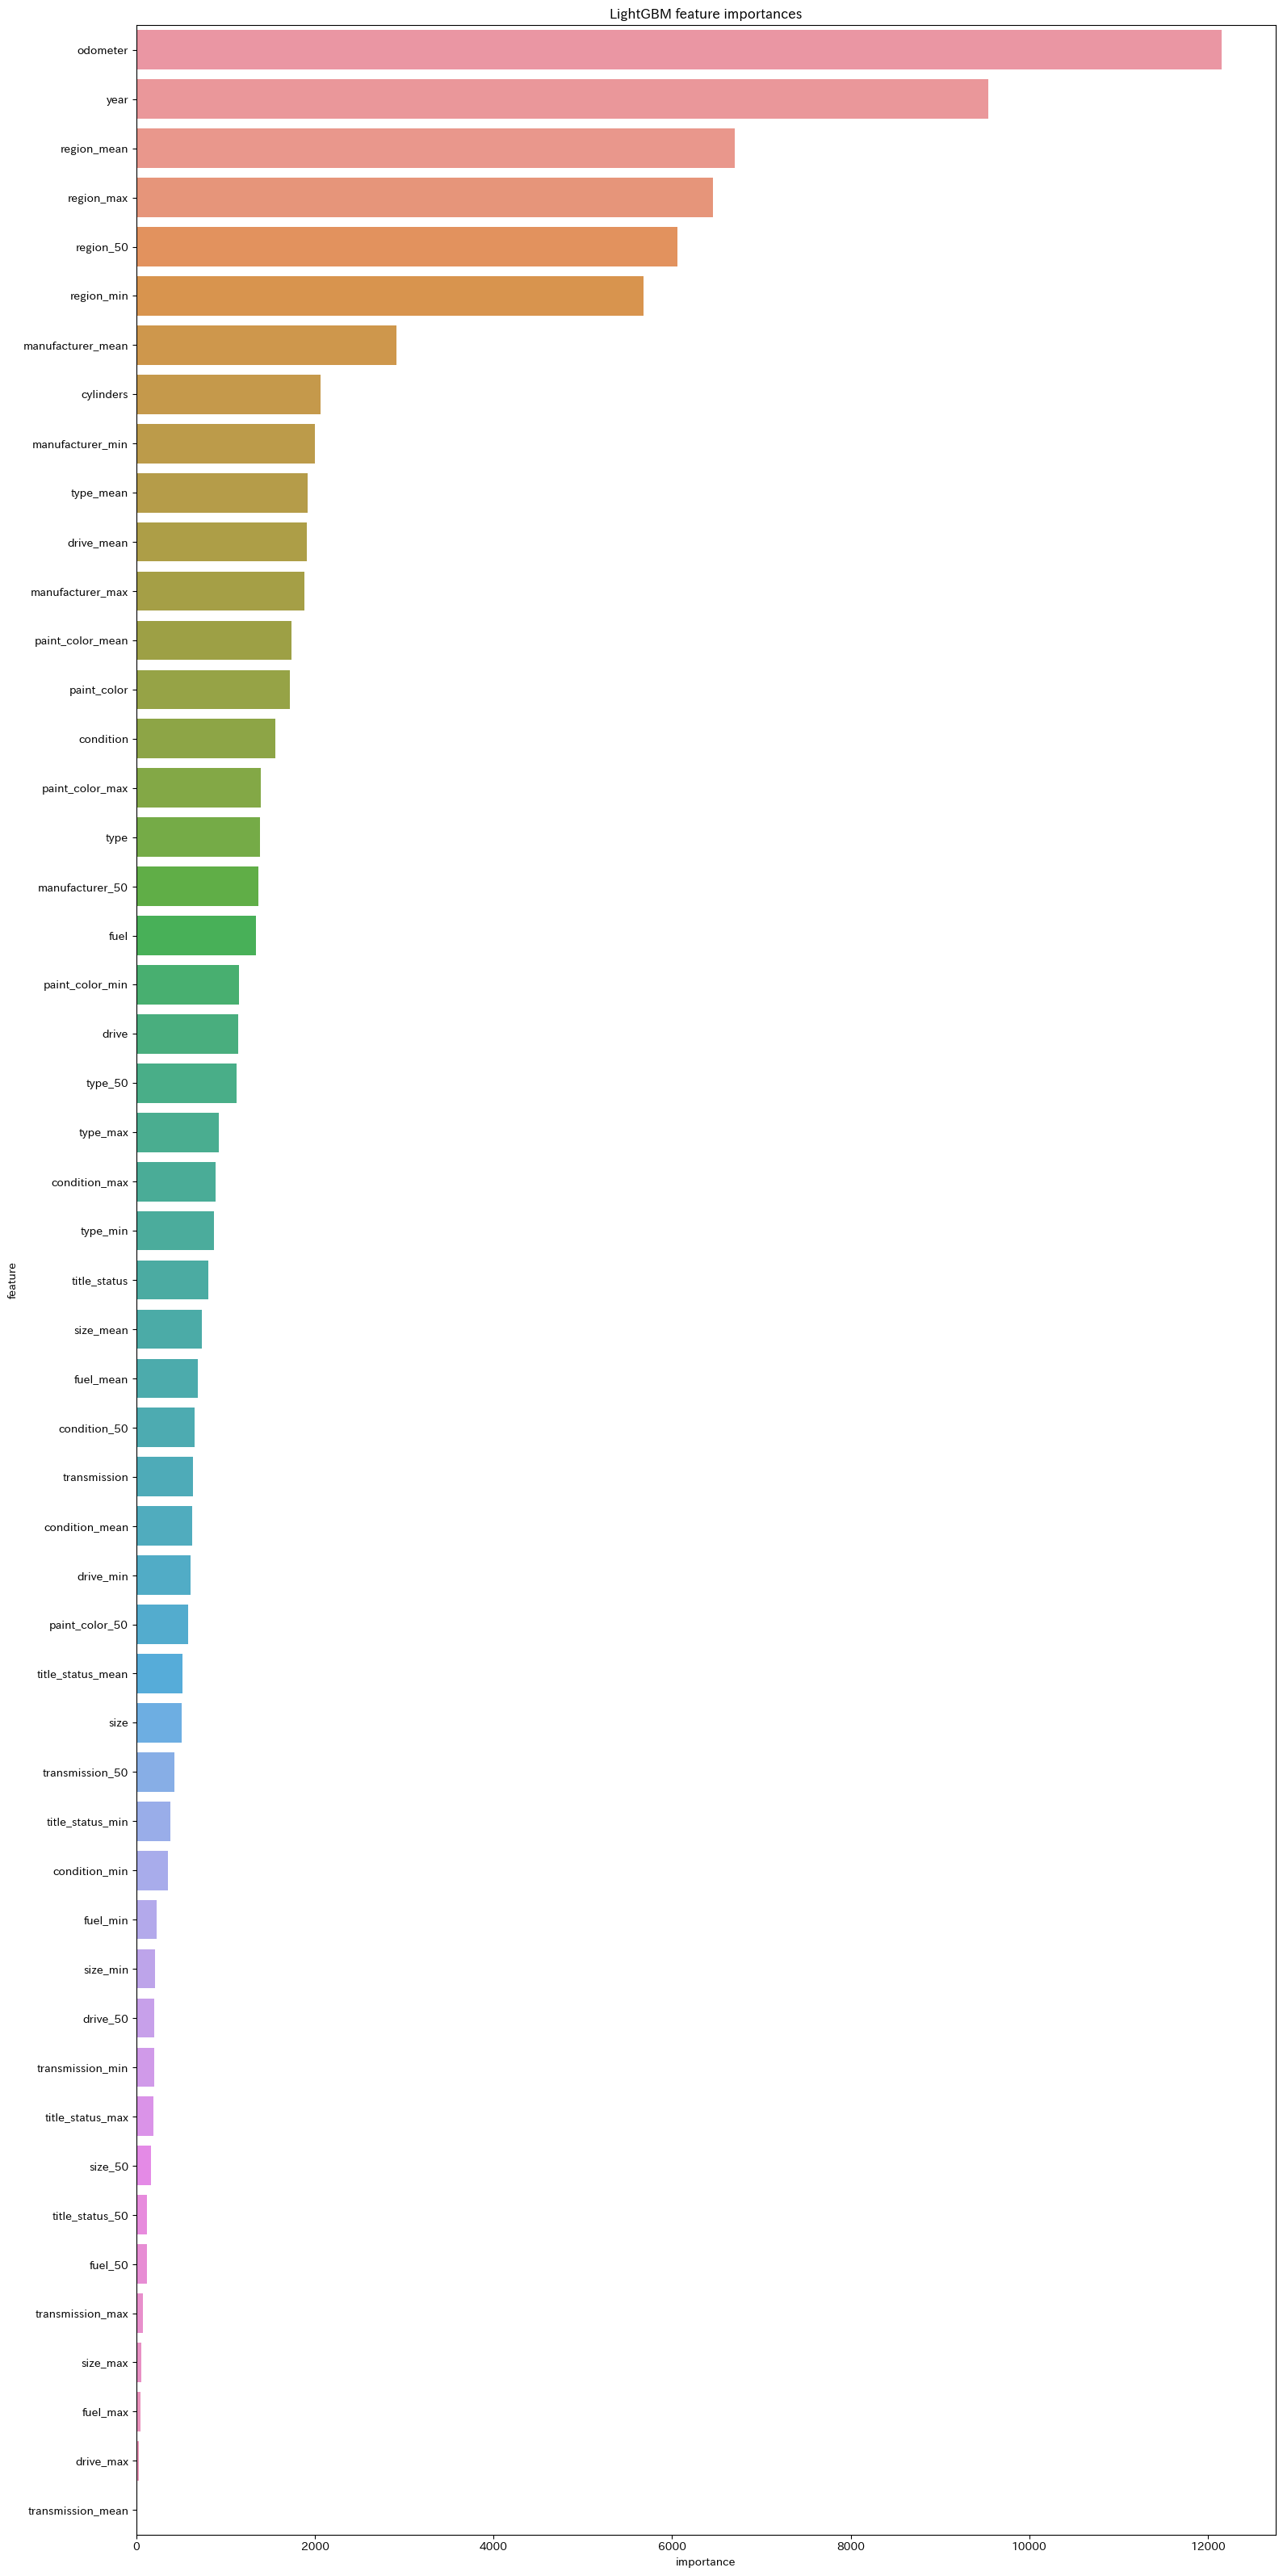

In [30]:
cv_training("lightgbm", train_df,feature_col, object_columns)

In [31]:
test_df["lightGBM_pred"] = model_inference("lightgbm",test_df ,train_x.columns, object_columns)

ValueError: Number of features of the model must match the input. Model n_features_ is 51 and input n_features is 54

In [ ]:
sub = sub[["id"]].merge(test_df[["id","lightGBM_pred"]], how="left", on="id")
sub.to_csv("submission.csv",index=False, header=False)
sub[["id","lightGBM_pred"]].head(10)